# Import libraries

In [8]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize
from shapely.geometry import box
from shapely.ops import linemerge
import shapely.ops
import matplotlib.pyplot as plt
from rasterio.plot import show
import os

## Configuration

In [3]:
RASTER_X_PATH = "../data/S2_Composite_AOI.tif"
VECTOR_Y_PATH = "../data/osm_coastline.gpkg"
OUTPUT_MASK_Y_PATH = "../data/mask_sea.tif"

## 1. Load Raster Data

In [4]:
try:
    with rasterio.open(RASTER_X_PATH) as s2_raster:
        s2_meta = s2_raster.meta.copy()
        s2_crs = s2_raster.crs
        s2_transform = s2_raster.transform
        s2_width = s2_raster.width
        s2_height = s2_raster.height
        s2_bounds = s2_raster.bounds

    print(f"--- Metadata of {RASTER_X_PATH} ---")
    print(f"CRS : {s2_crs}")
    print(f"Width : {s2_width} pixels")
    print(f"Height : {s2_height} pixels")
    print(f"Bounds : {s2_bounds}")
    print(f"Affine Transform : {s2_transform}")

except rasterio.errors.RasterioIOError:
    print(f"Error: Could not open raster file at {RASTER_X_PATH}. Please check the file path and try again.")
    print("Make sure the file exists and is accessible.")
    raise

--- Metadata of ../data/S2_Composite_AOI.tif ---
CRS : EPSG:32630
Width : 2754 pixels
Height : 1453 pixels
Bounds : BoundingBox(left=607850.0, bottom=5110480.0, right=635390.0, top=5125010.0)
Affine Transform : | 10.00, 0.00, 607850.00|
| 0.00,-10.00, 5125010.00|
| 0.00, 0.00, 1.00|


## 2. Load Vector Data

In [5]:
try:
    coastline_gdf = gpd.read_file(VECTOR_Y_PATH)
    print(f"\n--- Vector Data from {VECTOR_Y_PATH} ---")
    print(f"CRS initial : {coastline_gdf.crs}")

    # Reproject to match raster CRS
    coastline_gdf_utm = coastline_gdf.to_crs(s2_crs)
    print(f"New CRS after reprojection : {coastline_gdf_utm.crs}")
    print(f"Number of features : {len(coastline_gdf_utm)}")

except Exception as e:
    print(f"Error: Could not open vector file at {VECTOR_Y_PATH}. Please check the file path and try again.")
    raise e


--- Vector Data from ../data/osm_coastline.gpkg ---
CRS initial : EPSG:4326
New CRS after reprojection : PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]
Number of features : 26


## 3. Convert Lines to Polygons

In [9]:
# Create a bounding box polygon from raster bounds
bbox_poly = box(*s2_bounds)

# Create a unified geometry of the coastline
coastline_line = coastline_gdf_utm.unary_union

# Convert MultiLineString to LineString if necessary
if coastline_line.geom_type == 'MultiLineString':
    coastline_line = linemerge(coastline_line)
    print(f"Geometry type after merge: {coastline_line.geom_type}")

# If still MultiLineString, process each line separately
if coastline_line.geom_type == 'MultiLineString':
    print("Warning: Coastline is still a MultiLineString. Processing each line separately.")
    result_poly = bbox_poly
    for line in coastline_line.geoms:
        result_poly = shapely.ops.split(result_poly, line)
        # Flatten the result if it's a GeometryCollection
        if hasattr(result_poly, 'geoms'):
            result_poly = list(result_poly.geoms)
    split_polygons_geom = result_poly
else:
    # Split the bounding box polygon by the coastline line
    split_polygons_geom = shapely.ops.split(bbox_poly, coastline_line)

print(f"\nNumber of polygons after split: {len(list(split_polygons_geom.geoms) if hasattr(split_polygons_geom, 'geoms') else split_polygons_geom)}")

# Create a GeoDataFrame from the split polygons
if isinstance(split_polygons_geom, list):
    split_gdf = gpd.GeoDataFrame(geometry=split_polygons_geom, crs=s2_crs)
else:
    split_gdf = gpd.GeoDataFrame(geometry=list(split_polygons_geom.geoms), crs=s2_crs)


Geometry type after merge: LineString

Number of polygons after split: 2


## 4. Identify Sea Polygon

In [10]:
split_gdf['area_m2'] = split_gdf.geometry.area

# Assume the largest polygon is the sea
sea_polygon_gdf = split_gdf.nlargest(1, 'area_m2')

print(f"\nIdentified sea polygon area (m²): {sea_polygon_gdf['area_m2'].values[0]}")


Identified sea polygon area (m²): 315448975.9932349


## 5. Rasterize Sea Polygon to Create Mask

In [12]:
sea_shapes = [(geom, 1) for geom in sea_polygon_gdf.geometry]

mask_array = rasterize(
    shapes=sea_shapes,
    out_shape=(s2_height, s2_width),
    transform=s2_transform,
    fill=0, # value for non-sea areas
    default_value=1, # value for sea areas
    dtype=rasterio.uint8
)

print(f"\n--- Rasterization ---")
print(f"Mask Type: {type(mask_array)}")
print(f"Sea pixels (value=1): {np.sum(mask_array == 1)}")
print(f"Land pixels (value=0): {np.sum(mask_array == 0)}")


--- Rasterization ---
Mask Type: <class 'numpy.ndarray'>
Sea pixels (value=1): 3154512
Land pixels (value=0): 847050


## 6. Save Mask

In [13]:
mask_meta = s2_meta.copy()
mask_meta.update(
    count=1,              # single band
    dtype=rasterio.uint8, # data type
    nodata=None           # no nodata value
)

try:
    with rasterio.open(OUTPUT_MASK_Y_PATH, 'w', **mask_meta) as dst:
        dst.write(mask_array, 1)

    print(f"\n--- Save Mask ---")
    print(f"Mask saved successfully to: ")
    print(f"{OUTPUT_MASK_Y_PATH}")

except Exception as e:
    print(f"Error: Could not save mask to {OUTPUT_MASK_Y_PATH}. Please check the file path and permissions.")
    raise e


--- Save Mask ---
Mask saved successfully to: 
../data/mask_sea.tif


## 7. Visualize Mask

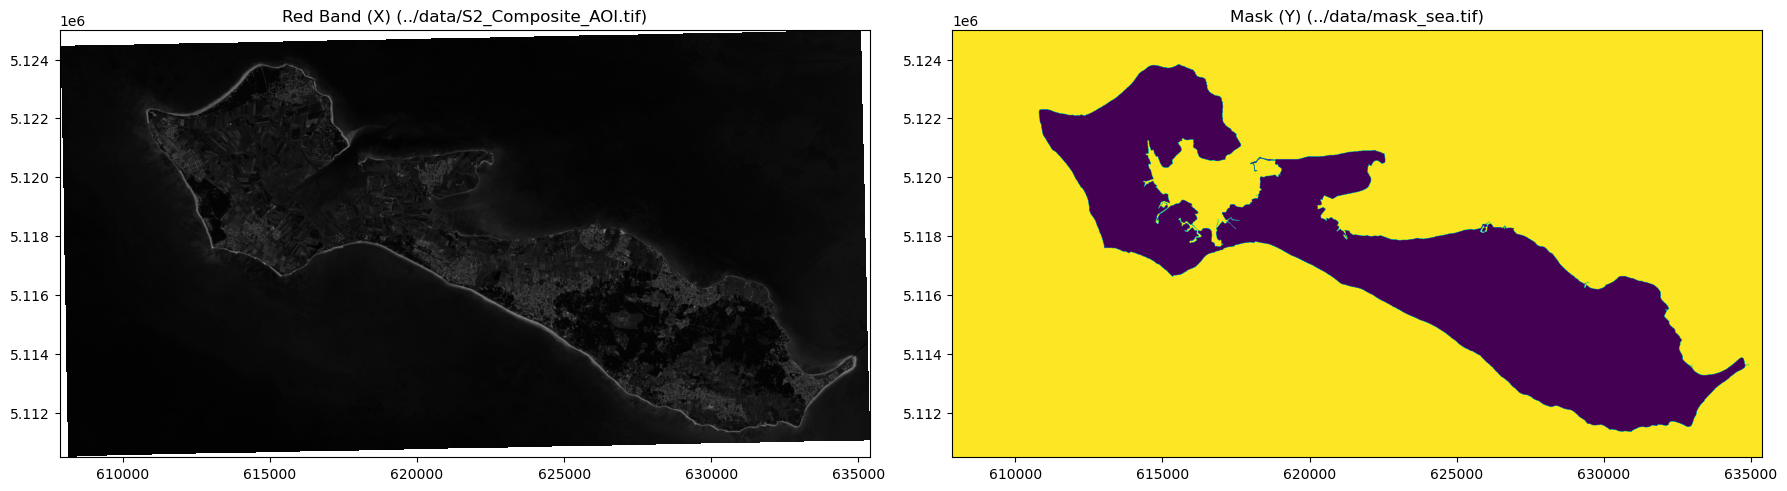

In [14]:
try:
    with rasterio.open(RASTER_X_PATH) as src_x, \
         rasterio.open(OUTPUT_MASK_Y_PATH) as src_y:

        # Read the red band from the raster image
        # (index 3 since rasterio uses 1-based indexing)
        # B4 (Red) is the 3rd index in 0-based indexing
        band_red = src_x.read(3)

        mask = src_y.read(1)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

        show(band_red, ax=ax1, transform=src_x.transform, cmap='gray')
        ax1.set_title(f"Red Band (X) ({RASTER_X_PATH})")

        show(mask, ax=ax2, transform=src_y.transform, cmap='viridis')
        ax2.set_title(f"Mask (Y) ({OUTPUT_MASK_Y_PATH})")

        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Error: Could not visualize data. Please check the file paths and try again.")